In [10]:
%matplotlib inline
%config InlineBackkend.figure_formats = ["png"]
import os
import sys
import re
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
cwd = Path(os.getcwd())
package_dir = cwd / 'packages'
sys.path.insert(0, str(package_dir))
from IPython.display import display

Funktionen:

In [11]:
#equivalenz Tabelle
eq_tb = {
    "person": "person",
    "Person": "person",
    #Fahrrad
    "bicycle": "bicycle",
    "Fahrrad ohne Anhänger": "bicycle",
    "Fahrrad mit Anhänger": "bicycle",
    "Lastenrad": "bicycle",
    #PKW
    "car": "car",
    "Pkw ohne Anhänger": "car",
    "Pkw mit Anhänger": "car",
    "Lieferwagen ohne Anhänger": "car",
    "Lieferwagen mit Anhänger": "car",
    #LKW
    "truck": "truck",
    "Lkw ohne Anhänger": "truck",
    "Lkw mit Anhänger": "truck",

    "motorcycle": "motorcycle",
    "Motorisierte Zweiräder": "motorcycle",

    "bus": "bus",
    "Bus": "bus",

}

In [12]:
import pandas as pd

def sort_time(df, col="DateTime"):
    """Sorts rows in dataframe by datetime"""
    df[col] = pd.to_datetime(df[col])
    filtered = df.sort_values(by=col)
    return filtered

def filter_df_by_range(df, t_min, t_max, col="DateTime"):
    """Filters dataframe by datetime range"""
    filtered = df[(df[col] >= t_min) & (df[col] < t_max)]
    return filtered

def array_similar(array1, array2):
    """Checks if 2 arrays contain the same strings"""
    if not len(array1) == len(array2):
        raise ValueError("Arrays don't have the same length!")
    for word in array1:
        if word in array2:
            continue
        else:
            raise ValueError("Arrays don't contain the same strings")
    return True

def get_gates(df1, df2, col="SectionID"):
    """Checks if two dataframes have identical values in column"""
    df1 = df1[col].unique()
    df2 = df2[col].unique()
    if array_similar(df1, df2):
        return df1
    else:
        raise ValueError("Dataframes have different values in the column")

def get_value_counts(df, sections, section_index, value="Class", section_name="SectionID"):
    """Returns value counts from dataframe for a specific section"""
    return df.loc[df[section_name] == sections[section_index], value].value_counts()

def extract_time(file_path):
    """
    Extracts the time from file name in the format "...yyyy-mm-dd_HH-MM-SS.csv".

    Args:
    file_path (str): The file path to extract the time from
    
    Returns:
    datetime.datetime object: The time extracted from the file name
    """
    pattern = r"(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})"
    match = re.search(pattern, file_path)
    if match:
        time_str = match.group(1)
        return datetime.datetime.strptime(time_str, '%Y-%m-%d_%H-%M-%S')
    else:
        return None

def get_right_positive(row, columns):
    """
    Returns the right positive classification.
    This works by comparing the min() value of the two rows
    Note that the value can`t go below 0!
    """
    return max(row[columns].min(), 0)

def get_false_positive(row, gt, eval):
    diff = row[gt] - row[eval]
    if diff < 0:
        return abs(diff)
    else:
        return 0
    
def get_false_negative(row, gt, eval):
    diff = row[gt] - row[eval]
    if diff > 0:
        return abs(diff)
    else:
        return 0
    
def format_timedelta(td):
    total_seconds = int(td.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f'{hours:02d}_{minutes:02d}_{seconds:02d}'

def on_file_upload(change):
    # Get the uploaded file
    uploaded_file = change['owner'].data[0]
    
    # Print the file name and contents
    print(f'Uploaded file "{uploaded_file.name}" with length {len(uploaded_file)}')
    print(uploaded_file)

Tabellen definieren

In [14]:
#settings
groundtruth = "data/gt_data/Saarbruecken_OTCamera04_FR20_2022-10-17_13-15-00.csv"
evaluate = "data/gtv_data/Saarbruecken_OTCamera04_FR20_2022-10-17_13-15-00_events.csv"
filename = "Saarbruecken_gt2gt_eval" + extract_time(groundtruth).strftime("%Y-%m-%d_%H-%M-%S")
cycle_feedback = False #seting for using the cycle_feedback funcitonality for motorcycles and bicycles
#end of settings
df_gt = pd.read_csv(groundtruth)
df_eval = pd.read_csv(evaluate) 
gates = get_gates(df_eval, df_gt)
df_gt["Class"] = df_gt["Class"].map(eq_tb)
df_eval["Class"] = df_eval["Class"].map(eq_tb)
df_eval = sort_time(df_eval)
df_gt = sort_time(df_gt)

#### Analysis section:
The following code will loop over all counting section and do a series of binary classification tests for all modes for different interval settings.

In [15]:
#setting for the interval
t_min = extract_time(groundtruth)
t_max = t_min + pd.Timedelta(minutes=15)  # Endzeit des Videos
interval = pd.timedelta_range(start="0 days", end="15 minutes", freq="10 s")  # Intervall
####
for gate_index, gate in enumerate(gates):  # geht alle Gates durch
    index = gate_index  # holt sich den index aus gate_index series

    for t_int in interval:  # geht Intervalleinstellung (Kalibrierung) durch
        if t_int == pd.Timedelta(0) or pd.Timedelta(minutes=15) % t_int != pd.Timedelta(0):
            continue  # wenn intervall nicht mod 15 ist überspringen

        t_end = t_min  # t_end
        df_merged2 = pd.DataFrame(columns=["Class", "gt", "eval", "rp", "fp", "fn", "t_start", "t_end"])
        
        while t_end <= (t_max - t_int):  # loopt alle Zeitintervalle
            t_start = t_end  # setzt intervall grenzen
            t_end = t_start + t_int

            df1 = filter_df_by_range(df_gt, t_start, t_end)  # filtert Spalten nach Zeitgrenzen
            df2 = filter_df_by_range(df_eval, t_start, t_end)

            df1 = get_value_counts(df1, gates, index)  # Summen für Class nach gateindex
            df2 = get_value_counts(df2, gates, index)

            df1 = pd.DataFrame(df1).reset_index().rename(columns={"index": "Class", "Class": "gt"})
            df2 = pd.DataFrame(df2).reset_index().rename(columns={"index": "Class", "Class": "eval"})

            df_merged = pd.merge(df1, df2, on="Class", how="outer")# setzt series zusammen
            df_merged = df_merged.fillna(0)

            df_merged["rp"] = df_merged.apply(lambda row: get_right_positive(row, ["gt", "eval"]), axis=1)
            df_merged["fp"] = df_merged.apply(lambda row: get_false_positive(row, "gt", "eval"), axis=1)
            df_merged["fn"] = df_merged.apply(lambda row: get_false_negative(row, "gt", "eval"), axis=1)

            df_merged_test = df_merged
            # Bicycle feedback
            if cycle_feedback:
                for target_class in ["bicycle", "motorcycle"]:
                    if not df_merged.loc[df_merged["Class"] == target_class].empty:  # Looks for rp target_class
                        if int(df_merged.loc[df_merged["Class"] == target_class, "rp"]) > 0:
                            rp_target = int(df_merged.loc[df_merged["Class"] == target_class, "rp"])  # Get value of rp target_class
                            if df_merged.loc[df_merged["Class"] == "person"].empty:
                                df_merged.loc[len(df_merged)] = ["person", 0, 0, 0, 0, 0]
                            eval_person = int(df_merged.loc[df_merged["Class"] == "person", "eval"])  # Get value of person
                            eval_person_adjusted = eval_person - rp_target
                            df_merged.loc[df_merged["Class"] == "person", "eval"] = eval_person_adjusted
                            df_merged["rp"] = df_merged.apply(lambda row: get_right_positive(row, ["gt", "eval"]), axis=1)
                            df_merged["fp"] = df_merged.apply(lambda row: get_false_positive(row, "gt", "eval"), axis=1)
                            df_merged["fn"] = df_merged.apply(lambda row: get_false_negative(row, "gt", "eval"), axis=1)
                            # Eval value can become negative in extreme cases! That functionality is intended!
                            # Note that right-positive values can't get negative by definition!

            df_merged["t_start"] = t_start.strftime("%H:%M:%S")
            df_merged["t_end"] = t_end.strftime("%H:%M:%S")

            if t_start == t_min:
                df_merged2 = df_merged
            else:
                df_merged2 = pd.concat([df_merged2, df_merged], ignore_index = True)
                del df_merged      
        
        df_merged2 = df_merged2.groupby(by="Class").sum(numeric_only=True)
        path = "./" + filename + "/" + gate
        filestring = "/" + gate + "-" + format_timedelta(t_int) + "-"+ t_min.strftime("%H_%M_%S") + "-"+t_max.strftime("%H_%M_%S") +".csv"
        if not os.path.exists(path):
            os.makedirs(path)
        df_merged2.to_csv((path + filestring), sep= ";")    

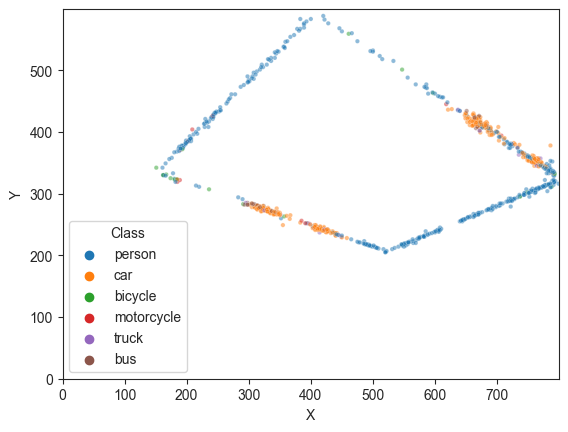

In [21]:
sns.set_style("ticks")
ax = sns.scatterplot(data = df_eval, x = "X", y = "Y", alpha = 0.5, s = 10, hue = "Class")
ax.set_xlim(0, 799),
ax.set_ylim(0, 599)
plt.savefig("test.png", dpi = 300)

In [38]:
gates[0]

'Haltelinie'